In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
data = pd.read_csv('../data/instagram_data.csv')
print(data.head())
print(data.shape)

    likes  no_of_comments           t  follower_count_at_t  \
0  154552               0  1594174009             40934474   
1   97386               0  1593571666             40934474   
2  145632               0  1593136341             40934474   
3   76461               0  1592981047             40934474   
4  174620               0  1592703461             40934474   

                 image_path  
0  ../Data/insta_data/0.jpg  
1  ../Data/insta_data/2.jpg  
2  ../Data/insta_data/4.jpg  
3  ../Data/insta_data/6.jpg  
4  ../Data/insta_data/8.jpg  
(3785, 5)


In [3]:
clean_data = pd.DataFrame()

**Removing Outliers**

In [5]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    clean_data = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return outliers, clean_data

In [6]:
outliers, clean_data = detect_outliers_iqr(data, 'likes')
print(f'Number of outliers: {len(outliers)}')
print(f'Cleaned data shape: {clean_data.shape}')


Number of outliers: 212
Cleaned data shape: (3573, 5)


**Cleaning Missing Data**

In [8]:
print(clean_data.isnull().sum()) 
clean_data = clean_data.dropna()

likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64


**Adding new features namely 'engagement percentage' = like/followers and 'is weekend'**

In [10]:
clean_data.loc[:,'engagement_percentage'] = (clean_data.loc[:,'likes'] / clean_data.loc[:,'follower_count_at_t']) * 100
clean_data.loc[:,'readable_time'] = pd.to_datetime(clean_data.loc[:,'t'], unit='s')
clean_data.loc[:,'is_weekend'] = clean_data.loc[:,'readable_time'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

bins = [0,100000, 150000,200000] 
labels = ['low', 'medium', 'high'] 
clean_data.loc[:,'likes_category'] = pd.cut(clean_data.loc[:,'likes'], bins=bins, labels=labels, right=False)

print(clean_data.columns)

Index(['likes', 'no_of_comments', 't', 'follower_count_at_t', 'image_path',
       'engagement_percentage', 'readable_time', 'is_weekend',
       'likes_category'],
      dtype='object')


**Plotting graphs**

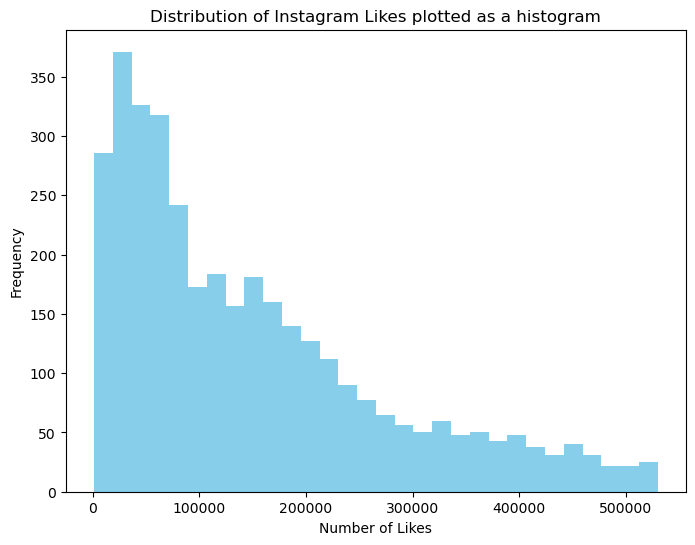

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(clean_data['likes'], bins=30, color='skyblue')
plt.title('Distribution of Instagram Likes plotted as a histogram')
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.show()

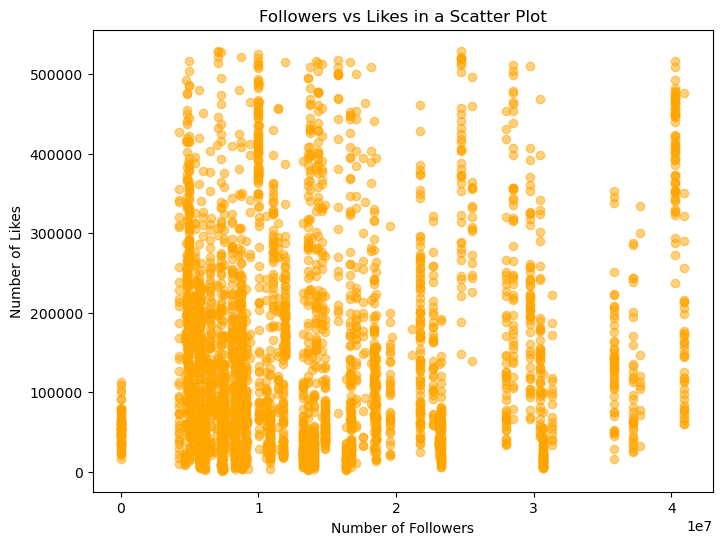

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(clean_data['follower_count_at_t'], clean_data['likes'], color='orange', alpha=0.5)
plt.title('Followers vs Likes in a Scatter Plot')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Likes')
plt.show()

In [14]:
new_order = clean_data.columns.tolist()  
column_to_move = new_order.pop(4)  # Remove the image path column from the dataframe
new_order.append(column_to_move)
clean_data = clean_data.reindex(columns=new_order)
clean_data

,likes,no_of_comments,t,follower_count_at_t,engagement_percentage,readable_time,is_weekend,likes_category,image_path
0,154552,0,1594174009,40934474,0.377560,2020-07-08 02:06:49,0,high,../Data/insta_data/0.jpg
1,97386,0,1593571666,40934474,0.237907,2020-07-01 02:47:46,0,low,../Data/insta_data/2.jpg
2,145632,0,1593136341,40934474,0.355769,2020-06-26 01:52:21,0,medium,../Data/insta_data/4.jpg
3,76461,0,1592981047,40934474,0.186789,2020-06-24 06:44:07,0,low,../Data/insta_data/6.jpg
4,174620,0,1592703461,40934474,0.426584,2020-06-21 01:37:41,1,high,../Data/insta_data/8.jpg
...,...,...,...,...,...,...,...,...,...
3780,341895,6029,1555164674,4229627,8.083337,2019-04-13 14:11:14,1,NaN,../Data/insta_data/9435.jpg
3781,217095,2591,1554706282,4229627,5.132722,2019-04-08 06:51:22,0,NaN,../Data/insta_data/9436.jpg
3782,17902,253,1553945996,4229627,0.423252,2019-03-30 11:39:56,1,low,../Data/insta_data/9437.jpg
3783,141694,1175,1552645088,4229627,3.350035,2019-03-15 10:18:08,0,medium,../Data/insta_data/9442.jpg


In [15]:
X = clean_data.drop(columns=['likes', 'likes_category', 'image_path', 't', 'readable_time'])  # Features
y = clean_data['likes_category']  # Target
X_final = X.dropna()
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
print(X_train.head(10))

      no_of_comments  follower_count_at_t  engagement_percentage  is_weekend
1107             712             14585967               1.898990           0
144             2145             40220549               0.875639           1
2015            1455              8838196               1.938801           0
700             1306             28457167               1.253906           0
1362             290             13601387               0.282905           0
2537             634              8079859               2.387096           1
687              733             28457167               0.865866           0
490              586             22711440               0.720509           0
3178             329              5394021               3.263725           0
2150             264              8328997               1.059431           1


In [16]:
def plotDatapoints(y_predz, string_algorithm):
    plt.figure(figsize=(8,6))
    plt.scatter(range(len(y_test)), y_test, label='True Values', color='blue', alpha=0.6)
    plt.scatter(range(len(y_predz)), y_predz, label='Predicted Values', color='red', alpha=0.6)
    plt.title('True vs Predicted Data Points for '+ string_algorithm)
    plt.xlabel('Index')
    plt.ylabel('Label')
    plt.legend()
    plt.show()

**Logistic Regression**

Logistic Regression Accuracy: 62.2824 %
Logistic Regression Error Rate: 37.7176 %
Confusion Matrix is: 
[[  0  81   0]
 [  1 322   0]
 [  0 113   0]]


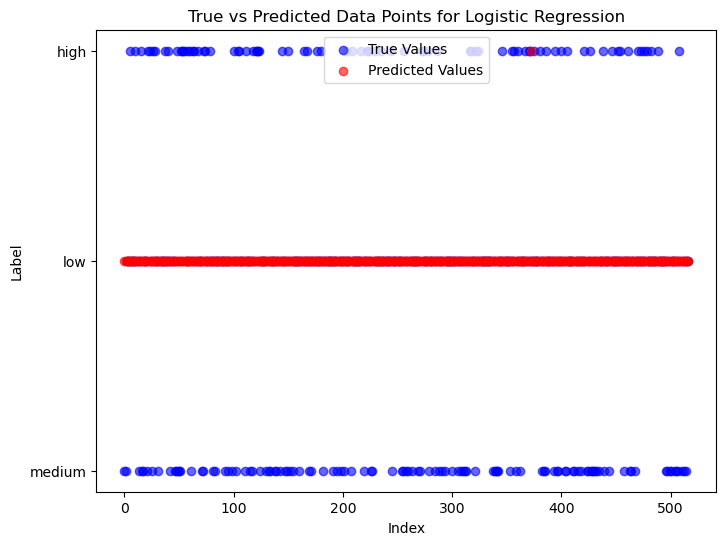

In [18]:
clean_dataz = clean_data.dropna()
y = clean_dataz['likes_category']  
X = clean_dataz.drop(columns=['likes', 'likes_category', 'image_path', 'readable_time', 't']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
log_reg = LogisticRegression(random_state=42, max_iter=1000)  
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
error_rate_log_reg = 1 - accuracy_log_reg
print(f"Logistic Regression Accuracy: {accuracy_log_reg*100:.4f} %")
print(f"Logistic Regression Error Rate: {error_rate_log_reg*100:.4f} %")
print(f"Confusion Matrix is: \n{metrics.confusion_matrix(y_test, y_pred_log_reg)}")
plotDatapoints(y_pred_log_reg, "Logistic Regression")

**KNN Classifier**

KNN Accuracy: 75.4352 %
KNN Error Rate: 24.5648 %
Confusion Matrix is: 
[[ 46  15  20]
 [ 10 301  12]
 [ 28  42  43]]


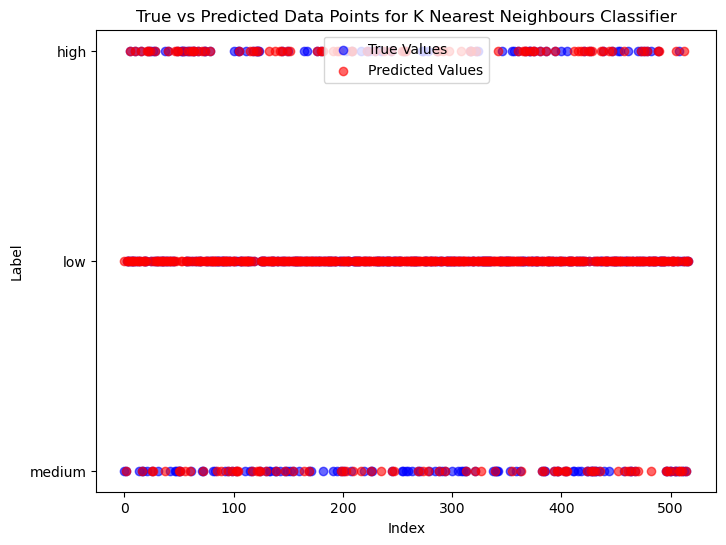

In [20]:
clean_dataz = clean_data.dropna()
y = clean_dataz['likes_category']  
X = clean_dataz.drop(columns=['likes', 'likes_category', 'image_path', 'readable_time', 't']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
error_rate_knn = 1 - accuracy_knn
print(f"KNN Accuracy: {accuracy_knn* 100:.4f} %")
print(f"KNN Error Rate: {error_rate_knn* 100:.4f} %")
print(f"Confusion Matrix is: \n{metrics.confusion_matrix(y_test, y_pred_knn)}")
plotDatapoints(y_pred_knn, "K Nearest Neighbours Classifier")

**Random Forest Classifier**

Random Forest Accuracy: 96.5184 %
Random Forest Error Rate: 24.5648 %
Confusion Matrix is: 
[[ 77   0   4]
 [  0 322   1]
 [ 10   3 100]]


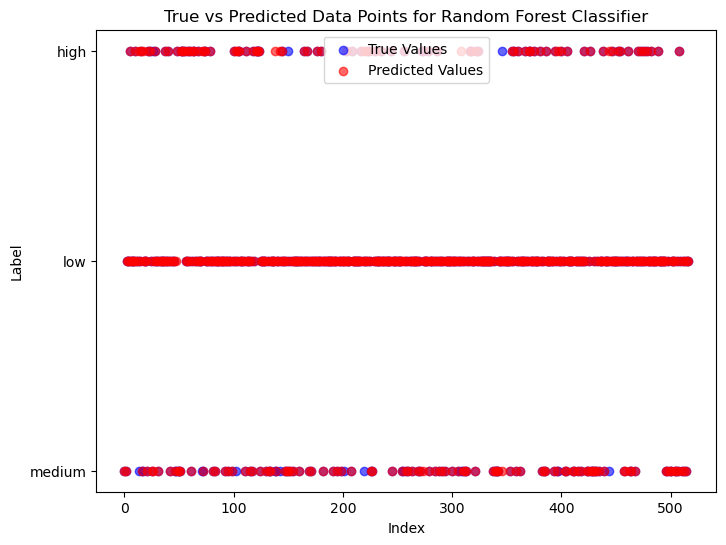

In [22]:
clean_dataz = clean_data.dropna()
y = clean_dataz['likes_category']  
X = clean_dataz.drop(columns=['likes', 'likes_category', 'image_path', 'readable_time', 't']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy

print(f"Random Forest Accuracy: {accuracy* 100:.4f} %")
print(f"Random Forest Error Rate: {error_rate_knn* 100:.4f} %")
print(f"Confusion Matrix is: \n{metrics.confusion_matrix(y_test, y_pred)}")
plotDatapoints(y_pred, "Random Forest Classifier")